In [1]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
import numpy as np

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


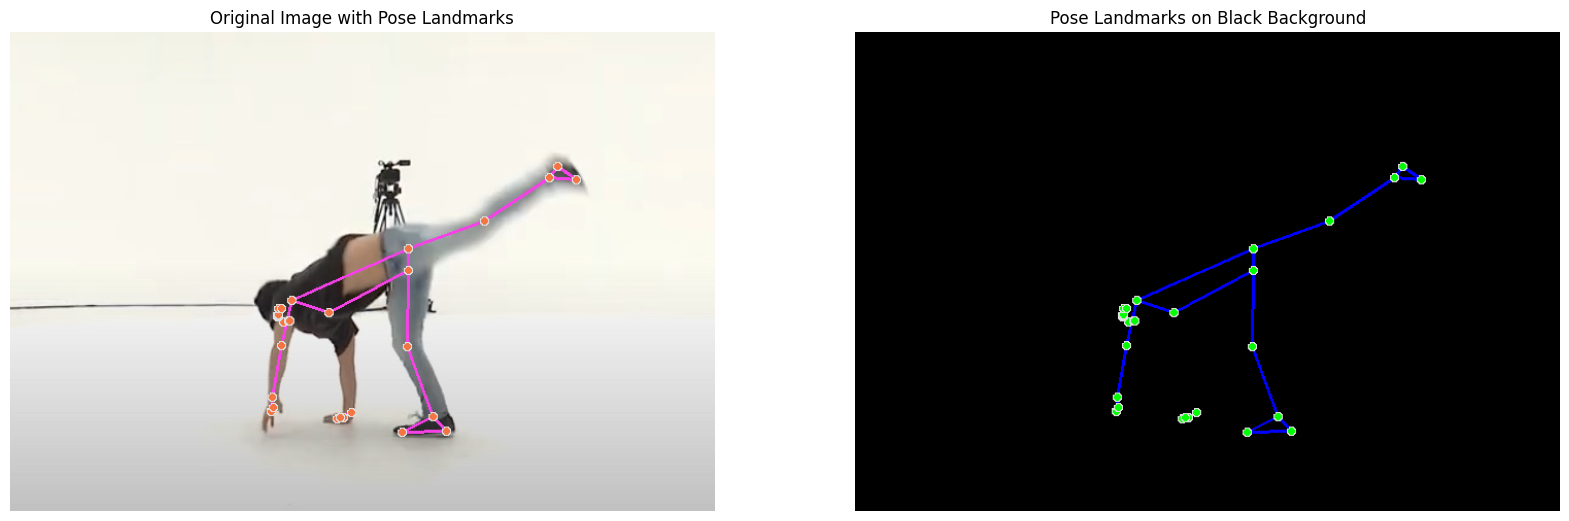

In [2]:
# Initialize MediaPipe Pose.
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True,
                    model_complexity=2,
                    enable_segmentation=False,
                    min_detection_confidence=0.5)

# Load an image.
image_path = 'c1.jpeg'
image = cv2.imread(image_path)

# Convert the BGR image to RGB.
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Process the image.
results = pose.process(image_rgb)

#Copy the image so we can draw on it.
image_output = image_rgb.copy()

# Draw pose landmarks on the image.
mp.solutions.drawing_utils.draw_landmarks(
    image_output, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
    landmark_drawing_spec=mp.solutions.drawing_utils.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2),
    connection_drawing_spec=mp.solutions.drawing_utils.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2))

#Create a blank image (black background) for drawing.
image_black_bg = np.zeros_like(image_rgb)

# Draw pose landmarks on the black background image.
mp.solutions.drawing_utils.draw_landmarks(
    image_black_bg, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
    landmark_drawing_spec=mp.solutions.drawing_utils.DrawingSpec(color=(0,255,0), thickness=2, circle_radius=2),
    connection_drawing_spec=mp.solutions.drawing_utils.DrawingSpec(color=(0,0,255), thickness=2, circle_radius=2))

# Plotting the images side by side.
fig, ax = plt.subplots(1, 2, figsize=(20,10))  # 1 row, 2 columns

# Display original image with landmarks.
ax[0].imshow(image_output)
ax[0].set_title('Original Image with Pose Landmarks')
ax[0].axis("off")

# Display landmarks on black background.
ax[1].imshow(image_black_bg)
ax[1].set_title('Pose Landmarks on Black Background')
ax[1].axis("off")

plt.show()


In [13]:
import torch

model = torch.hub.load('harritaylor/torchvggish', 'vggish')
model.eval()

# Download an example audio file
# import urllib
# url, filename = ("http://soundbible.com/grab.php?id=1698&type=wav", "bus_chatter.wav")
# try: urllib.URLopener().retrieve(url, filename)
# except: urllib.request.urlretrieve(url, filename)
filename = 'data/trimmed_audio/2031.mp3'

x = model.forward(filename)
print(x.shape)

Using cache found in /home/elias/.cache/torch/hub/harritaylor_torchvggish_master


torch.Size([98, 128])


In [9]:
print(model.forward(filename)[0])

tensor([186.,  33., 180., 103., 216.,  93., 115.,  85., 114., 255., 139.,  37.,
        153., 156., 134.,  63., 125., 106., 157., 164.,  38., 161.,  82., 103.,
         87., 143., 166., 151., 185., 160., 163., 117., 152., 161.,  39., 167.,
        133., 119., 126., 122., 167., 155.,   0., 151., 128., 174.,  91., 169.,
         93., 158., 164., 165., 114., 141., 146., 105., 208.,  34., 171., 199.,
        187.,  76., 122., 173., 133., 251., 140.,  72., 148., 188.,  65., 178.,
        246., 255., 175., 147., 149., 255., 137., 202., 152., 143., 170., 179.,
          3.,  88.,  65., 214., 136., 113., 161., 138., 149., 164., 183., 197.,
         36.,  45.,  73., 211., 176., 150., 106.,  45.,  45., 242., 113., 165.,
        255., 164., 122., 255.,  52., 119., 255.,  38., 106., 130.,   0.,   0.,
        255.,  10.,  84.,  78., 123.,  71.,  23., 255.],
       grad_fn=<SelectBackward0>)


In [ ]:
import os
from pydub import AudioSegment

def trim_audio_files(directory, output_directory, trim_milliseconds=15000):
    """
    Trims the first 'trim_milliseconds' from audio files in the specified directory.
    Saves the trimmed audio files to 'output_directory'.
    """
    # Ensure output directory exists
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    # Process each file in the directory
    for filename in os.listdir(directory):
        # Check file extension to determine if it's an audio file
        if filename.endswith(".mp3") or filename.endswith(".wav"):  # Add or modify file types if needed
            path = os.path.join(directory, filename)
            output_path = os.path.join(output_directory, filename)

            try:
                # Load the audio file
                audio = AudioSegment.from_file(path)

                # Trim the first 15 seconds
                if len(audio) > trim_milliseconds:
                    trimmed_audio = audio[trim_milliseconds:]

                    # Determine the format based on the file extension
                    format = filename.split('.')[-1]
                    # Export the trimmed audio to the same format
                    trimmed_audio.export(output_path, format=format)
                    print(f"Processed {filename} successfully.")
                else:
                    print(f"File {filename} is too short to be trimmed.")
            except Exception as e:
                print(f"Could not process {filename}. Error: {e}")

# Usage example
source_directory = 'data/MEMD_audio'
destination_directory = 'data/trimmed_audio'
trim_audio_files(source_directory, destination_directory)


In [5]:
from moviepy.editor import VideoFileClip
import os

def process_videos(input_dir, audio_output_dir, video_output_dir, default_fps=60):
    # Ensure output directories exist
    os.makedirs(audio_output_dir, exist_ok=True)
    os.makedirs(video_output_dir, exist_ok=True)

    # Iterate through all files in the input directory
    for filename in os.listdir(input_dir):
        if filename.endswith(".mp4"):
            # Construct the full file path
            full_path = os.path.join(input_dir, filename)

            # Load the video file
            try:
                clip = VideoFileClip(full_path)
            except Exception as e:
                print(f"Error loading video {filename}: {e}")
                continue

            # Check if clip has 'fps' attribute, else use default_fps
            video_fps = clip.fps if clip.fps is not None else default_fps

            # Extract audio from the video and save as MP3
            audio_filename = os.path.splitext(filename)[0] + '.mp3'
            audio_path = os.path.join(audio_output_dir, audio_filename)
            if clip.audio:
                clip.audio.write_audiofile(audio_path)
            else:
                print(f"No audio found in {filename}")

            # Remove audio from the video and save the result
            video_filename = os.path.splitext(filename)[0] + '_noaudio.mp4'
            video_path = os.path.join(video_output_dir, video_filename)
            try:
                clip.without_audio().write_videofile(video_path, codec='libx264', fps=video_fps)
            except Exception as e:
                print(f"Error writing video file {video_filename}: {e}")

            # Close the clip to free resources
            clip.close()


input_directory = 'dance_to_emo/data/dance_genre_estimation'
mp3_directory = 'dance_to_emo/data/music'
no_audio_video_directory = 'dance_to_emo/data/dance'
process_videos(input_directory, mp3_directory, no_audio_video_directory)


MoviePy - Writing audio in dance_to_emo/data/music/gPO_sFM_c01_d10_mPO1_ch02.mp3


MoviePy - Done.
Moviepy - Building video dance_to_emo/data/dance/gPO_sFM_c01_d10_mPO1_ch02_noaudio.mp4.
Moviepy - Writing video dance_to_emo/data/dance/gPO_sFM_c01_d10_mPO1_ch02_noaudio.mp4



TypeError: must be real number, not NoneType